<a href="https://colab.research.google.com/github/YDayoub/DCGANs-animefaces/blob/main/DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional GAN (DCGAN)

In [1]:
# import used libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary
import os
import urllib
import zipfile
from skimage import io
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
def show_tensor_images(imgs,img_nums=25,shape=(3,64,64)):
  imgs = imgs[:img_nums].detach().to('cpu')
  imgs = (imgs+1)/2
  imgs = imgs.view((-1,*shape))
  imgs_grid = make_grid(imgs,nrow=5)
  plt.imshow(imgs_grid.permute(1, 2, 0).squeeze())
  plt.axis('off')
  plt.show()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# generator class
from functools import reduce
from operator import __add__
def mk_generator_blk(in_channels,out_channels,kernel_size=4,stride=2,padding=0,final_layer=False,use_upsampling=False,output_size = None):
  '''
 This function return generator block, has the following arch:
  if not final_layer:
    if use_upsampling:
        upsampling=>padding=>conv=>BatchNorm=>LeakyReLU
    else:
        convTranspose=>BatchNorm=>LeakyRelu
  else:
      if use_upsampling:
      upsampling=>padding=>conv=>Tanh
  else:
      convTranspose=>Tanh

  Args:
    in_channels: dims of input channels
    out_channels: dims of output channels
    kernel_size: size of used kernel in conv/convTranpose
    stride: size of stride
    padding: size of padding
    final_layer: boolean to indicate if this is the final layer or not
    use_upsampling: boolean to indicate whether to use upsampling or convTranpose
    output_size: output_size of upsampling
  
  '''
  if use_upsampling:
    # zero padding code taken from:
    # https://stackoverflow.com/questions/58307036/is-there-really-no-padding-same-option-for-pytorchs-conv2d
    kernel_sizes = (kernel_size,kernel_size)
    conv_padding = reduce(__add__, 
    [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in kernel_sizes[::-1]])
    scale = nn.Sequential(
        nn.Upsample((output_size, output_size), mode='nearest'),
        nn.ZeroPad2d(conv_padding),
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=0)
    )
           
  else:
    scale = nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)
  if final_layer:
    return nn.Sequential(scale,nn.Tanh())
  else:
    return nn.Sequential(scale,nn.BatchNorm2d(num_features=out_channels), nn.LeakyReLU(negative_slope=0.2))


class Generator(nn.Module):
  '''
  Generator class
  '''
  def __init__(self,im_channel,z_dims,hidden_dims,use_upsampling=False):
    '''
    Args:
      im_channels: number of final output channels
      z_dims: noise vector dims
      hidden_dims: hidden vector dims, we use pyramids as follow:
        z_dims => 4*hidden_dims=> 2*hidden_dims => hidden_dims => im_channels
      use_upsampling: boolean to indicate whether to use upsampling or convTranspose,
      A good article to read:
      https://distill.pub/2016/deconv-checkerboard/
    '''
    super(Generator, self).__init__()
    self.im_channel = im_channel
    self.z_dims = z_dims
    self.gen = nn.Sequential(
        mk_generator_blk(z_dims,4*hidden_dims,use_upsampling=use_upsampling,output_size=4),
        mk_generator_blk(4*hidden_dims,2*hidden_dims,kernel_size=4,stride=2,use_upsampling=use_upsampling,output_size=16),
        mk_generator_blk(2*hidden_dims,hidden_dims,use_upsampling=use_upsampling,kernel_size=3,output_size=32),
        mk_generator_blk(hidden_dims,im_channel,stride =3,kernel_size=4,use_upsampling=use_upsampling,final_layer=True,output_size=64)
        
    )
  def forward(self,x):
    '''
    forward path of the network
    '''
    return self.gen(x)

   
def getNoise(shape,device):
  '''
  get noise vector on device
  '''
  z = torch.randn(shape,device = device)
  return z


In [3]:
def mk_discriminator_blk(in_channels,out_channels,kernel_size=4,stride=2,final_layer=False):
  '''
 This function return discriminator block, which has the following arch:
  if not final_layer:
        Conv=>BatchNorm=>LeakyRelu
  else:
      Conv

  Args:
    in_channels: dims of input channels
    out_channels: dims of output channels
    kernel_size: size of used kernel in conv
    stride: size of stride
    padding: size of padding
    final_layer: boolean to indicate if this is the final layer or not
    '''
  if not final_layer:
            return nn.Sequential(
               
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                         kernel_size=kernel_size,stride = stride),
                nn.BatchNorm2d(num_features = out_channels),
                nn.LeakyReLU(negative_slope=0.2)            )
  else: # Final Layer
      return nn.Sequential(
        
          nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                    kernel_size=kernel_size,stride = stride)
      )

class Discrminator(nn.Module):
  '''
  Discriminator class
  '''
  def __init__(self,hidden_dims):
    '''
    Args:
      hidden_dims: hidden vector dims, we use pyramids as follow:
                      hidden_dims=>2*hidden_dims=>1
    '''
    super(Discrminator, self).__init__()
    
    self.disc = nn.Sequential(
        mk_discriminator_blk(im_channel,hidden_dims,kernel_size=6,stride=3),
        mk_discriminator_blk(hidden_dims,2*hidden_dims,kernel_size=6,stride=3),
        mk_discriminator_blk(2*hidden_dims,1,final_layer=True)
            )
  def forward(self,x):
    '''
    forward pass network
    '''
    res = self.disc(x)
    return res.view(x.shape[0],-1)


In [4]:
# Define constants
z_dims = 512
batch_size=64
hidden_dims = 128
im_channel=3
display_step = 500
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
n_epochs = 10
img_size = 64
save_model = False


In [5]:
# Get Generator summary
gen = Generator(im_channel=im_channel,z_dims=z_dims,hidden_dims=hidden_dims).to(device)
summary(gen,(z_dims,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       4,194,816
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4          [-1, 256, 10, 10]       2,097,408
       BatchNorm2d-5          [-1, 256, 10, 10]             512
         LeakyReLU-6          [-1, 256, 10, 10]               0
   ConvTranspose2d-7          [-1, 128, 21, 21]         295,040
       BatchNorm2d-8          [-1, 128, 21, 21]             256
         LeakyReLU-9          [-1, 128, 21, 21]               0
  ConvTranspose2d-10            [-1, 3, 64, 64]           6,147
             Tanh-11            [-1, 3, 64, 64]               0
Total params: 6,595,203
Trainable params: 6,595,203
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [6]:
# Get discriminator summary
disc = Discrminator(hidden_dims=hidden_dims).to(device)
summary(disc,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 20, 20]          13,952
       BatchNorm2d-2          [-1, 128, 20, 20]             256
         LeakyReLU-3          [-1, 128, 20, 20]               0
            Conv2d-4            [-1, 256, 5, 5]       1,179,904
       BatchNorm2d-5            [-1, 256, 5, 5]             512
         LeakyReLU-6            [-1, 256, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           4,097
Total params: 1,198,721
Trainable params: 1,198,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.32
Params size (MB): 4.57
Estimated Total Size (MB): 5.94
----------------------------------------------------------------


In [7]:
#Weights_initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas=(beta_1,beta_2))
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr,betas=(beta_1,beta_2))
criterion = torch.nn.BCEWithLogitsLoss()


In [8]:
'''
Download datasets,
datasets is hosted on laurencemoroney blog
'''

try:
  os.mkdir('/content/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/content/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([img_size,img_size]),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [10]:
import glob
class animeDataset(Dataset):
  def __init__(self,image_dir,transform=None):
    self.image_files = glob.glob(image_dir+'/*.jpg')
    self.transform = transform
  def __len__(self):
    return len(self.image_files)
  def __getitem__(self,idx):
    sample = io.imread(self.image_files[idx])
    if self.transform:
      sample = self.transform(sample)
    return sample
anime_dataset = animeDataset('/content/anime/images',transform=transform)

In [11]:
dataloader = torch.utils.data.DataLoader(anime_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 1- Step 500: Generator loss: 0.9589697489291416, discriminator loss: 0.07542022202722733


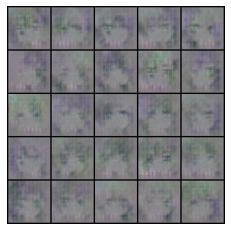

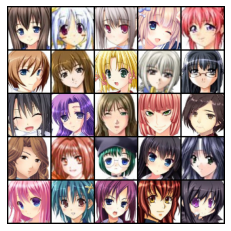

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 2- Step 1000: Generator loss: 0.6586366214081639, discriminator loss: 0.16309466960281122


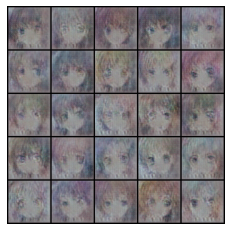

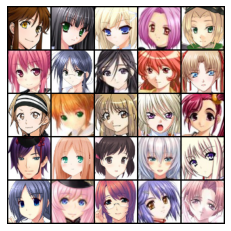

Epoch 2- Step 1500: Generator loss: 0.506918560810388, discriminator loss: 0.19286050963401805


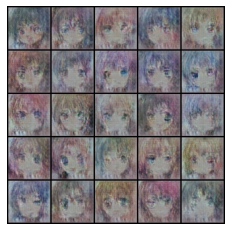

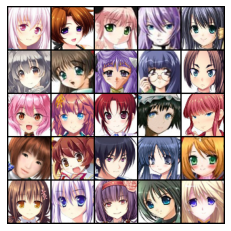

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 3- Step 2000: Generator loss: 0.4740837623625994, discriminator loss: 0.1910304199755191


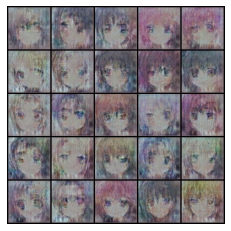

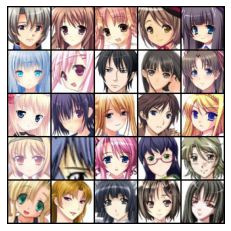

Epoch 3- Step 2500: Generator loss: 0.48710384778678406, discriminator loss: 0.18428786537051198


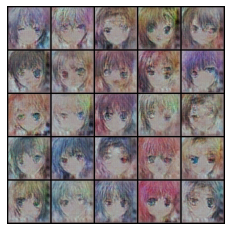

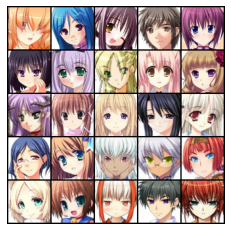

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 4- Step 3000: Generator loss: 0.49137164823710966, discriminator loss: 0.18937056595087046


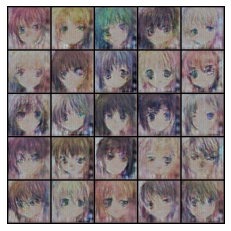

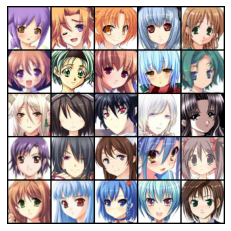

Epoch 4- Step 3500: Generator loss: 0.4614110458604991, discriminator loss: 0.20091966992616653


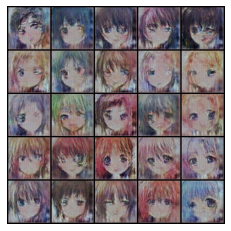

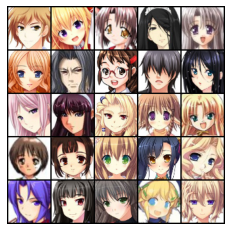

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 5- Step 4000: Generator loss: 0.46532438005507043, discriminator loss: 0.20103388684988027


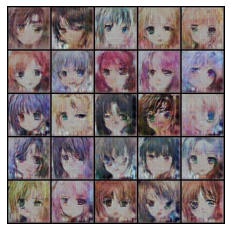

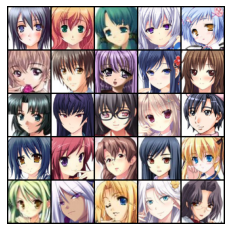

Epoch 5- Step 4500: Generator loss: 0.45388143014907867, discriminator loss: 0.20323570364713672


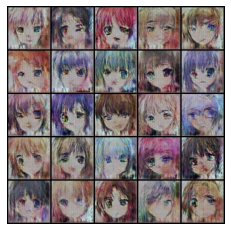

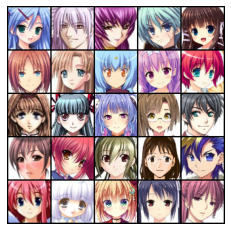

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 6- Step 5000: Generator loss: 0.4378361236304046, discriminator loss: 0.209722989141941


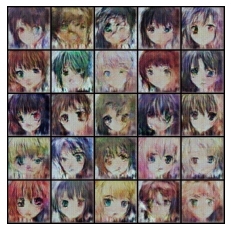

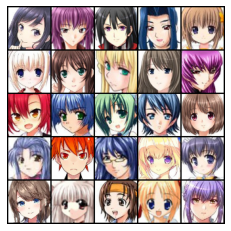

Epoch 6- Step 5500: Generator loss: 0.4299512649625541, discriminator loss: 0.21366447532176966


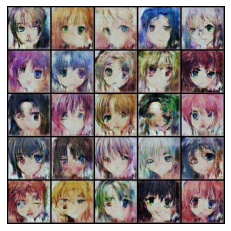

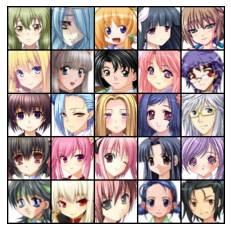

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 7- Step 6000: Generator loss: 0.41286080306768386, discriminator loss: 0.22070866504311573


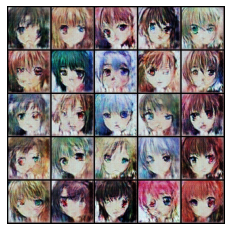

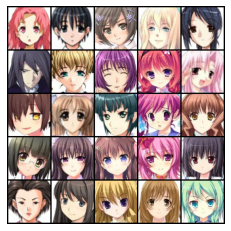

Epoch 7- Step 6500: Generator loss: 0.39581596291065263, discriminator loss: 0.22526562064886121


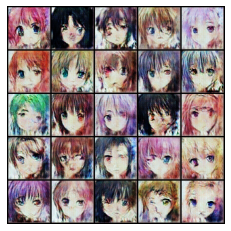

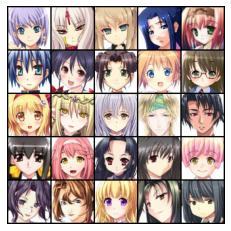

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 8- Step 7000: Generator loss: 0.38522603012621376, discriminator loss: 0.22924176383018505


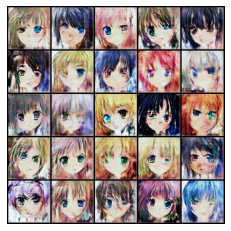

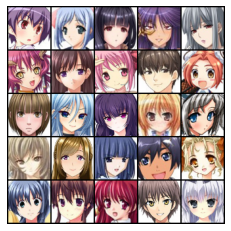

Epoch 8- Step 7500: Generator loss: 0.3797520547211172, discriminator loss: 0.23046303632855417


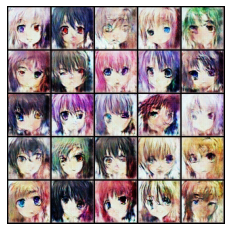

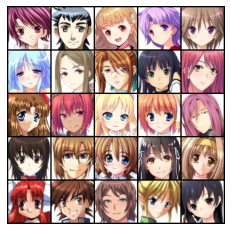

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 9- Step 8000: Generator loss: 0.3702064387351273, discriminator loss: 0.2344518818855285


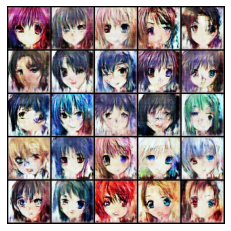

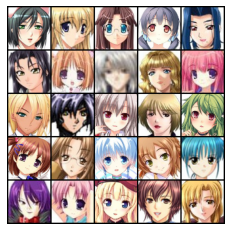

Epoch 9- Step 8500: Generator loss: 0.36721286047995094, discriminator loss: 0.23384427991509446


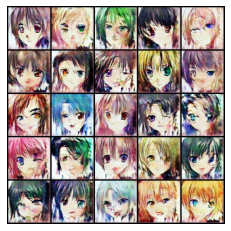

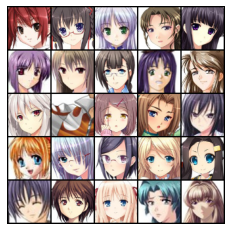

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch 10- Step 9000: Generator loss: 0.3644604722857477, discriminator loss: 0.2336421426832674


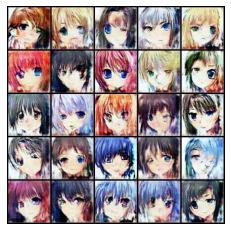

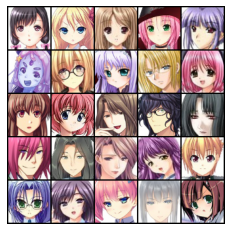

Epoch 10- Step 9500: Generator loss: 0.36331177777051915, discriminator loss: 0.23347971177101137


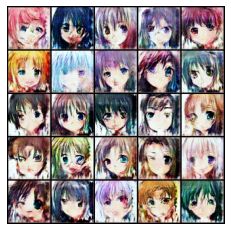

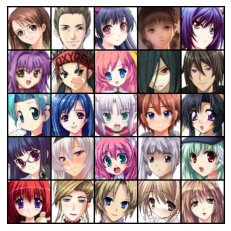

In [12]:
# training
cur_step = 0
mean_discriminator_loss = 0
mean_generator_loss = 0
for epoch in range(n_epochs):
  for real in tqdm(dataloader):
    shape = (len(real),z_dims,1,1)
    real = real.to(device)
    ## check real image
    disc_opt.zero_grad()
    ypred = disc(real)
    real_loss = torch.mean((ypred-torch.ones_like(ypred))**2)
    z = getNoise(shape,device)
    with torch.no_grad():
      fake_images = gen(z)  
    ypred = disc(fake_images)
    fake_loss = torch.mean((ypred-torch.zeros_like(ypred))**2)
    loss = (real_loss+fake_loss)/2
    mean_discriminator_loss += loss.item()/display_step
    loss.backward()
    disc_opt.step()
    gen_opt.zero_grad()
    shape = (5*len(real),z_dims,1,1)
    fake_images = gen(getNoise(shape,device))
    ypred = disc(fake_images)
    #loss_gen = criterion(ypred,torch.ones_like(ypred))
    loss_gen = torch.mean((ypred-torch.ones_like(ypred))**2)
    mean_generator_loss+=loss_gen.item()/display_step
    loss_gen.backward()
    gen_opt.step()

    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Epoch {epoch+1}- Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      show_tensor_images(fake_images)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
      if save_model:
                    torch.save({
                        'disc': disc.state_dict(),
                        'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_opt': disc_A_opt.state_dict(),
                    }, f"DCGAN_{cur_step}.pth")
    cur_step += 1